<a href="https://colab.research.google.com/github/urieliram/tc_uc/blob/main/Figures_TC_UC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paquetes

In [1]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Gráficos
# ==============================================================================
from matplotlib import style
import seaborn as sns
cm = 1/2.54

# Modelado y test estadísticos
# ============================================================================
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp
from scipy import stats
from scipy.stats import shapiro
import scipy.stats as stats

# Configuración matplotlib
# ==============================================================================
# Gráficos distribución observada 
# ============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')
import seaborn as sns
# plt.style.use('ggplot')

## Lectura de archivo de resultados stat.xls

In [2]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
# URL  = 'https://drive.google.com/file/d/1ySF5y3FdEZrEAu1jZ_P1PdBJSk64TQvt/view?usp=share_link'
# df   = pd.read_csv(path+URL.split('/')[-2],header=0)
URL        = 'https://docs.google.com/spreadsheets/d/12byid7r6dwnpYgbWWrvWrYQtlFfsPhI6Meq9tcF-DBU/edit?usp=sharing'
sheet_id   = '12byid7r6dwnpYgbWWrvWrYQtlFfsPhI6Meq9tcF-DBU'
sheet_name = 'stat1'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
df   = pd.read_csv(url,header=0)
# df.dropna(inplace=True)
# filter = 'x7day_large' ## x7day_small, x7day_large , x10gen_large
# df = df[df['groupx'] == filter]

# GRÁFICOS DE CONVERGENCIA milp, milp2, hard3, harjk lbc, ks, 


## Lectura de archivos log

In [3]:
## Lectura de datos
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Log1.zip to Log1.zip
User uploaded file "Log1.zip" with length 511440 bytes


In [4]:
# !pip install unrar
# !unrar x "/content/Logs1.rar"

In [5]:
!unzip "Log1.zip" -d "/content"

Archive:  Log1.zip
  inflating: /content/Log_071.log    
  inflating: /content/Log_072.log    
  inflating: /content/logfileMilp2uc_072.log  
  inflating: /content/logfileMilp2uc_071.log  
  inflating: /content/logfileMilp2uc_065.log  
  inflating: /content/logfileMilp2uc_064.log  
  inflating: /content/logfileMilp2uc_063.log  
  inflating: /content/logfileMilp2uc_061.log  
  inflating: /content/Log_065.log    
  inflating: /content/Log_064.log    
  inflating: /content/Log_063.log    
  inflating: /content/Log_074.log    
  inflating: /content/logfileMilp2uc_074.log  
  inflating: /content/Log_061.log    
  inflating: /content/logfileMilp2uc_073.log  
  inflating: /content/Log_073.log    
  inflating: /content/Log_066.log    
  inflating: /content/logfileMilp2uc_066.log  
  inflating: /content/Log_075.log    
  inflating: /content/logfileMilp2uc_075.log  
  inflating: /content/logfileMilp2uc_067.log  
  inflating: /content/Log_067.log    
  inflating: /content/Log_076.log    
  inflat

In [6]:
def validateFiles():
  list=[]
  f = open("/content/Logs.txt","r")
  validFiles = [i.replace("\n","") for i in f]
  #print(validFiles)
  f.close()
  onlyfiles = [f.split(".")[0] for f in listdir("/content") if isfile(join("/content", f))]
  for i in validFiles:
    list.append(i)
    if i not in onlyfiles:
      print(i)
      return False
  return True, list
list=[]
if validateFiles() is False:
   print("!!! Faltan archivos")   
   temp, list = validateFiles()
   print(list)
else:
   temp, list = validateFiles()
   print("Archivos completos")
   

Archivos completos


## Extrae información de los logs

In [7]:
class ExtractCPLEX:

  def findPos(self,file,spected, starter = "Node  Left"):
    file = open(file,"r")
    for i,j in enumerate(file):
      if starter in j:
        return [(j.index(k)+len(k)-1) for k in spected]
  
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*Logfile\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp

  def createTables(self,fn):
    table_start = False
    spected = ['Node', 'Left', 'Objective', 'IInf', 'Integer', 'Bound', 'ItCnt', 'Gap']
    expectedPositions = self.findPos(fn,spected)
    tables = {"seconds":[],"ticks":[],"solution":[],"Node":[],"Left":[],"Objective":[],"IInf":[],"Integer":[],"Bound":[],"ItCnt":[],"Gap":[],"cuts":[]}
    time = None
    ticks = None
    cuts = None
    f = open(fn,"r")    
    for i in f:
      if re.findall(r"\d{1,}[+]{1}\d{1,}",i):
        i = " ".join(i.split("+"))
      if("Cover cuts applied" in i or "Performing restart 1" in i):
        table_start = False
      if("Elapsed time" in i):
          tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          time = tmp[0]
          ticks = tmp[1]
      if(table_start):        
        if((str(i)[0] == " " or str(i)[0] == "*") and str(i)[expectedPositions[0]].isdigit()):
          i = i.replace("uts: "," uts:")
          tables["seconds"].append(time)
          tables["ticks"].append(ticks)
          tables["solution"].append(1 if i[0]=="*" else 0)
          tables["cuts"].append(None)
          for j,m in zip(expectedPositions,spected):
            if i[j] != " ":
              tmp = ""
              for k in range(j,0,-1):
                if i[k] != " ":
                  tmp += i[k]
                else: 
                  break 
              tmp = tmp[::-1]
              if("ut" in tmp.lower() or "infeasible" in tmp.lower() or "integral" in tmp.lower()):
                if("uts" in tmp.lower()):
                  tables["cuts"][-1] = int(tmp.split(":")[1])
                tables[m].append(tables[m][-1])
              else:
                if m == "Gap":
                  tables[m].append(float(tmp)/100)
                else: 
                  tables[m].append(float(tmp))
            else:
              tables[m].append(None)
      if("Node  Left"):
        table_start = True

    return tables

  def extract(self,fn):
    variables = {"mipPresolveEliminated":[],"mipPresolveModified":[],"aggregatorDid":[],"reducedMipHasColumns":[],"reducedMipHasNonZero":[],"reducedMipHasBinaries":[],"reducedMipHasGeneral":[],"cliqueTableMembers":[],"rootRelaxSolSeconds":[],"rootRelaxSolTicks":[]}
    variables["logFile"] = self.getFilelog(fn)
    tables = self.createTables(fn)
    f = open(fn, "r")    
    for i in f:
      if("linear optimization" in i):
        variables["linearOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("optimality gap tolerance" in i):
        variables["gapTol"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("time limit in seconds" in i):
        variables["timeLimit"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("emphasis for MIP optimization" in i):
        variables["mipOpt"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Objective sense" in i):
        variables["objSense"] = i.replace(" ","").replace("\n","").split(":")[1]
      if("Variables" in i):
        if("Box:" in i):
          variablesValue = ["variablesValue","Nneg","Box","Binary"]
          for j,k in enumerate(re.findall(r'\d+', i.replace(" ","").replace("\n","").split(":",1)[1])):
            variables[variablesValue[j]] = float(k)
        else:
          variablesValue = ["minLB","maxUb"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
      if("Objective nonzeros" in i):
        if("Min" in i or "Max" in i):
          variablesValue = ["objNonZerosMin","objNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["objNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("Linear constraints" in i):
        if("Less" in i):
          variablesValue = ["linearConstraintsValue","less","greater","equal"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          pass
      if("Nonzeros" in i):
        if("Min" in i):
          variablesValue = ["nonZerosMin","nonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["nonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("RHS nonzeros" in i):
        if("Min" in i):
          variablesValue = ["rhsNonZerosMin","rhsNonZerosMax"]
          for j,k in enumerate(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)):
            variables[variablesValue[j]] = float(k)
        else:
          variables["rhsNonZeros"] = float(i.replace(" ","").replace("\n","").split(":")[1])
      if("CPXPARAM_TimeLimit" in i):
        variables["CPXPARAM_TimeLimit"] = float(i.replace("\n","").split(" ")[-1])
      if("MIP Presolve eliminated" in i):
        variables["mipPresolveEliminated"].append([int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)])
      if("MIP Presolve modified " in i):
        variables["mipPresolveModified"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Reduced MIP has" in i):
        if("indicators." in i):
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasBinaries"].append(tmp[0])
          variables["reducedMipHasGeneral"].append(tmp[1])
        else:
          tmp = [int(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
          variables["reducedMipHasColumns"].append(tmp[1])
          variables["reducedMipHasNonZero"].append(tmp[-1])
          reduceHasGeneral = []
      if("Clique" in i):
        variables["cliqueTableMembers"].append(float(i.replace(" ","").replace("\n","").split(":")[1]))
      if("Aggregator did" in i):
        variables["aggregatorDid"].append(int(re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)[0]))
      if("Root relaxation" in i):
        tmp = [float(k) for k in re.findall('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?',i)]
        variables["rootRelaxSolSeconds"].append(tmp[0])
        variables["rootRelaxSolTicks"].append(tmp[1])
      if("Lift and" in i):
        variables["liftAndProjectCuts"] = int(i.replace(" ","").replace("\n","").split(":")[1])
      if("Gomory fractional" in i):
        variables["gomoryFract"] = int(i.replace(" ","").replace("\n","").split(":")[1])

    df=pd.DataFrame.from_dict(tables).rename(columns={"seconds":"seconds","ticks":"ticks","solution":"solution","Node":"node","Left":"nodesLeft","Objective":"objective","IInf":"iinf","Integer":"bestInteger","Bound":"BestBound","ItCnt":"itCnt","Gap":"gap","cuts":"cuts"})
    df['seconds'] = df['seconds'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["seconds"] + df["eps"]
    df["seconds"] = sum_column
    df['ticks'] = df['ticks'].fillna(0)
    eps=np.arange(0, 1, 1/(len(df)), dtype=float)
    df['eps'] = eps
    sum_column = df["ticks"] + df["eps"]
    df["ticks"] = sum_column
    return df,variables

In [8]:
class Extract:
  def __init__(self,log):
    self.log = log 
  def getFilelog(self,f):
    with open(f, 'r') as file:
      data = file.read().replace('\n', '')
    tmp = []
    for i in re.findall(r"\w*"+self.log+"\s*\'*[a-zA-z.+]*\'",data):
      tmp.append(i.replace("'","").split(" ")[1])
    return tmp
  def extract(self):
    fn= "/content/"+self.log+".log"
    variables = {}
    variables["logFile"] = self.log.replace("Log","uc")
    f = open(fn, "r")
    for i in f:
      # if("z_milp=" in i):
      #   variables["z_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_milp2=" in i):
        variables["z_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_harjk=" in i):
        variables["z_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("z_hard3=" in i):
        variables["z_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])        
      # if("t_milp=" in i):
      #   variables["t_milp"]  = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_milp2=" in i):
        variables["t_milp2"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_harjk=" in i):
        variables["t_harjk"] = float(i.replace(" ","").replace("\n","").split("=")[1])
      if("t_hard3=" in i):
        variables["t_hard3"] = float(i.replace(" ","").replace("\n","").split("=")[1])

    # variables["flag_milp" ] = False
    variables["flag_milp2"] = False
    variables["flag_harjk"] = False
    variables["flag_hard3"] = False

    # if variables["z_milp"]  != 1E+75:
    #   variables["flag_milp"] = True
    if variables["z_milp2"] != 1E+75:
      variables["flag_milp2"] = True
    if variables["z_harjk"] != 1E+75:
      variables["flag_harjk"] = True
    if variables["z_hard3"] != 1E+75:
      variables["flag_hard3"] = True
    start = ["lbc1 results","lbc2 results","lbc3 results","lbc4 results","KS results"]
    stop  = ["lbc1 end"    ,"lbc2 end"    ,"lbc3 end"    ,"lbc4 end"    ,"KS end"    ]
    for p in range(5):
      pattern_start = re.compile(r""+start[p])
      pattern_stop  = re.compile(r""+"^"+stop[p])
      i = 0
      extract_on = False
      extracts = []
      with open(r''+fn, 'rt') as myfile:
          for line in myfile:
              i += 1  # line counting starts with 1
              if pattern_start.match(line):
                  extract_on = True
              if pattern_stop.search(line):
                  extract_on = False
              if extract_on:
                  extracts.append((i, line.rstrip('\n')))
      listlines=[]; x=[]; y=[]
      for line in extracts:
        listlines.append(line[1])
      if len(listlines)!=0:
        del listlines[0]
      for i in listlines:
        if float(re.split(',',i.replace(" ",""))[1])!=1E+75:
          x.append(float(re.split(',',i.replace(" ",""))[0]))
          y.append(float(re.split(',',i.replace(" ",""))[1]))
      if p==0:
        variables["t_lbc1"] = x
        variables["z_lbc1"] = y
        variables["flag_lbc1"] = True
      if p==1:
        variables["t_lbc2"] = x
        variables["z_lbc2"] = y
        variables["flag_lbc2"] = True
      if p==2:
        variables["t_lbc3"] = x
        variables["z_lbc3"] = y
        variables["flag_lbc3"] = True
      if p==3:
        variables["t_lbc4"] = x
        variables["z_lbc4"] = y
        variables["flag_lbc4"] = True
      if p==4:
        variables["t_KS"] = x
        variables["z_KS"] = y
        variables["flag_KS"] = True
    return variables

ex         = Extract('Log_083')
variablesx = ex.extract()
print(variablesx)

{'logFile': 'uc_083', 't_hard3': 1231.6, 'z_hard3': 45600581.9, 't_harjk': 1232.2, 'z_harjk': 45634621.0, 't_milp2': 7273.7, 'z_milp2': 45574974.6, 'flag_milp2': True, 'flag_harjk': True, 'flag_hard3': True, 't_lbc1': [1231.6076774597168, 1365.2, 2604.8, 3844.9, 5085.3, 6326.0, 7268.5], 'z_lbc1': [45600581.90630723, 45575217.205789715, 45574974.605790235, 45574974.60578767, 45574974.605789, 45574974.60578766, 45574974.60578902], 'flag_lbc1': True, 't_lbc2': [1231.6076774597168, 1372.5, 2612.9, 3853.6, 5094.2, 6334.6, 7268.6], 'z_lbc2': [45600581.90630723, 45574974.605789796, 45574974.605787605, 45574974.60578863, 45574974.60578766, 45574974.60578884, 45574974.60578766], 'flag_lbc2': True, 't_lbc3': [1231.6076774597168, 1372.3, 2612.3, 3852.8, 5093.1, 6333.1, 7268.1], 'z_lbc3': [45600581.90630723, 45574974.605789796, 45574974.605787605, 45574974.605788946, 45574974.60578759, 45574974.60578895, 45574974.60578763], 'flag_lbc3': True, 't_lbc4': [1231.6076774597168, 1419.4, 2662.4, 3906.2, 

In [9]:
## Test ExtractCPLEX
#e = ExtractCPLEX()
#df, dic = e.extract("/content/logfileMilp2uc_061.log")
#df.plot.line( x='seconds',y='bestInteger',style='o-',label='_nolegend_')

## Despliega gráficas

In [45]:
def graficas(title='',graphs=[]):
  plt.figure()
  models = ['MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
  i=0
  group_=''
  for tup in graphs:
      x    = tup[0]
      y    = tup[1]
      if tup[2]:
        if i==0:
          plt.plot(x, y, 'x',  label = models[i],markersize=7,color='magenta')
        else:
          plt.plot(x, y, '.-', label = models[i],markersize=7,)
      i=i+1
  if title !='uc_063':
    if title !='uc_064':
      if title !='uc_065':
        if title !='uc_066':      
          if title !='uc_067':
            if title !='uc_068':
              if title !='uc_070':
                e  = ExtractCPLEX()
                df3, dic = e.extract("/content/logfileMilp2"+title+".log")
                a  = df3['seconds'].values.tolist()
                ar = np.array(a)

                df1      = df[df['nameins'] == title+'.json' ]
                t_harduc = int(df1.t_harduc)
                ar       = ar + t_harduc ## Agregamos los segundos de Harduc
                groupx   = str(df1.groupx.iloc[0])

                plt.plot( ar,df3['bestInteger'].values.tolist(),'x',color='magenta')
  plt.xlabel("Time (seconds)")
  plt.ylabel("z ($)")
  plt.title('Instance '+title+'\n ('+groupx+')')
  plt.legend(bbox_to_anchor=(1, 0.75))
  plt.tight_layout()
  plt.savefig('fig:'+title+'.pdf')
  # plt.show()
  return 0

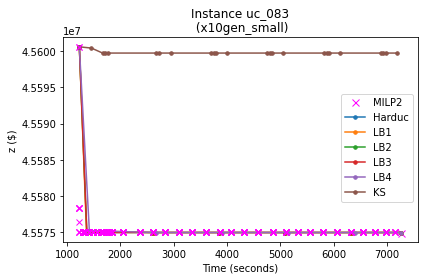

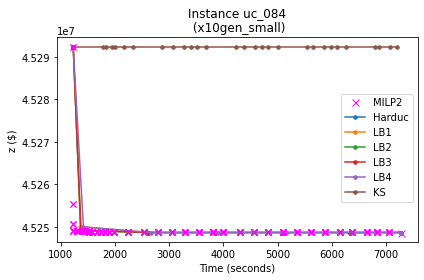

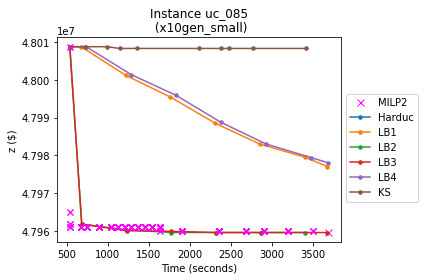

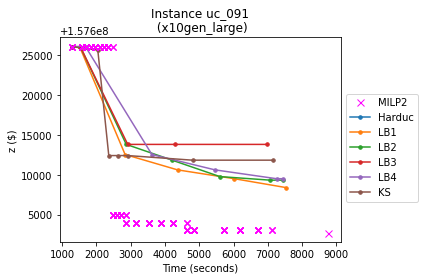

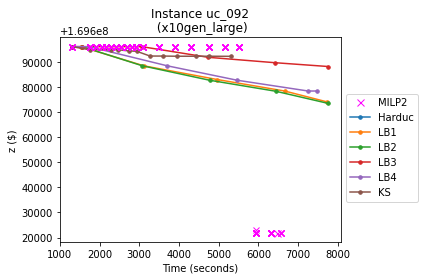

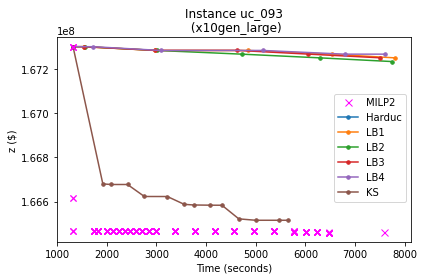

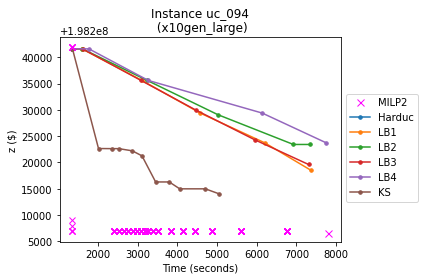

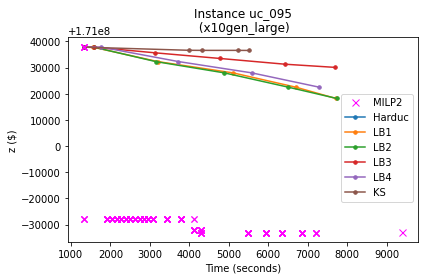

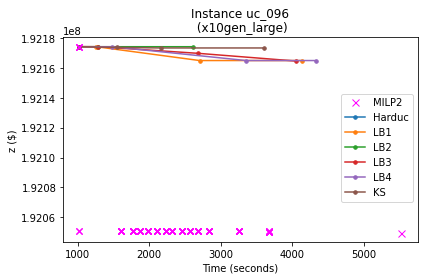

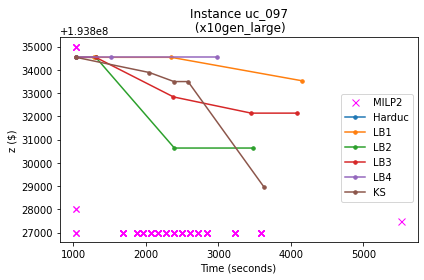

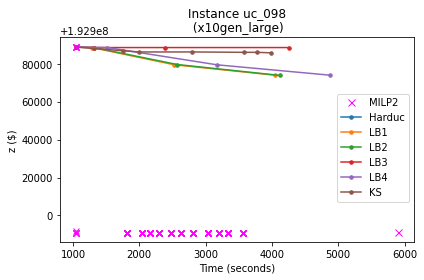

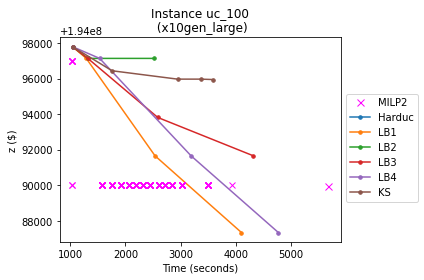

In [46]:
for item in list:
    list2  = []
    graphs = []
    try:
      e = Extract(item)
      variables = e.extract()
      if True:
        variables["flag_harjk"] = False
        # graphs.append(([variables['t_milp' ]],[variables['z_milp']] ,variables["flag_milp"]))
        graphs.append(([variables['t_milp2']],[variables['z_milp2']],variables["flag_milp2"]))
        graphs.append(([variables['t_harjk']],[variables['z_harjk']],variables["flag_harjk"]))
        graphs.append(([variables['t_hard3']],[variables['z_hard3']],variables["flag_hard3"]))
        graphs.append((variables['t_lbc1' ],variables['z_lbc1' ],variables["flag_lbc1"]))
        graphs.append((variables['t_lbc2' ],variables['z_lbc2' ],variables["flag_lbc2"]))
        graphs.append((variables['t_lbc3' ],variables['z_lbc3' ],variables["flag_lbc3"]))
        graphs.append((variables['t_lbc4' ],variables['z_lbc4' ],variables["flag_lbc4"]))
        graphs.append((variables['t_KS' ],variables['z_KS' ],variables["flag_KS"]))
        title = variables["logFile"]
        graficas(title=title,graphs=graphs)
      list2.append(variables)
    except Exception as err:
      print("Fail in ", item+".log"+ " file")
      print(str(err))

## Carga de resultados de stat


In [47]:
filter = 'x7day_large' ## x7day_small, x7day_large , x10gen_large , x10gen_small
df2 = df[df['groupx'] == filter]

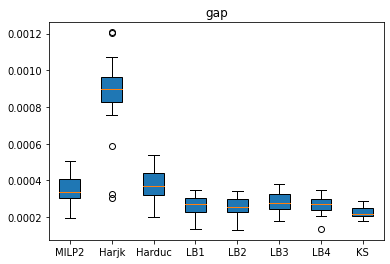

In [48]:
##Imprimir GAP
# data1  = pd.to_numeric(df2.z_milp).to_numpy()
milp2   = pd.to_numeric(df2.g_milp2).to_numpy()
harjk   = pd.to_numeric(df2.g_harjk).to_numpy()
harduc  = pd.to_numeric(df2.g_harduc).to_numpy()
lbc1    = pd.to_numeric(df2.g_lbc1).to_numpy()
lbc2    = pd.to_numeric(df2.g_lbc2).to_numpy()
lbc3    = pd.to_numeric(df2.g_lbc3).to_numpy()
lbc4    = pd.to_numeric(df2.g_lbc4).to_numpy()
ks      = pd.to_numeric(df2.g_ks).to_numpy()
labels  = ['MILP2','Harjk','Harduc','LB1','LB2','LB3','LB4','KS']
x       = [milp2,harjk,harduc,lbc1,lbc2,lbc3,lbc4,ks]
fig,ax  = plt.subplots()
ax.set_title('gap')
bp = ax.boxplot(x,           
positions=[2,3,4,5,6,7,8,9],         # where to put these arrays
labels = labels, patch_artist=True)  # allow filling the box with colors
# ax.legend()
namefile = 'fig:boxplotgap'+'.pdf'
plt.savefig(namefile, transparent=True)
plt.show()

## Análisis estadístico descriptivo

In [49]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
method  = ['Harjk' ]*(len(harjk))
method2 = ['Harduc']*(len(harduc))
method  = method + method2
data    = np.concatenate((harjk, harduc), axis=0)
# initialise data of lists.
data = {'gap' :data, 'method' :method}  
df1 = pd.DataFrame( data )

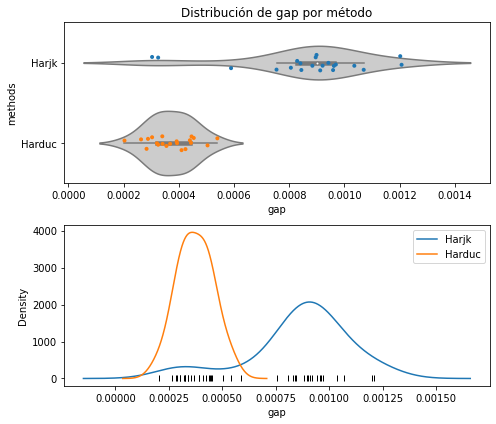

In [50]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]  )
  axs[0].set_title('Distribución de gap por método')
  axs[0].set_ylabel('methods')
  axs[0].set_xlabel('gap')

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].set_xlabel('gap')
  axs[1].legend()

  fig.tight_layout()

In [51]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
method1 = ['Milp2' ]*(len(milp2))
method2 = ['LB1'   ]*(len(lbc1))
method3 = ['LB2'   ]*(len(lbc2))
method4 = ['LB3'   ]*(len(lbc3))
method5 = ['LB4'   ]*(len(lbc4))
method6 = ['KS'    ]*(len(ks))
method  = method1 + method2 + method3 + method4 + method5 + method6
data    = np.concatenate((milp2,lbc1,lbc2,lbc3,lbc4,ks), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
#fig, ax = plt.subplots(figsize=(8, 6))
#sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

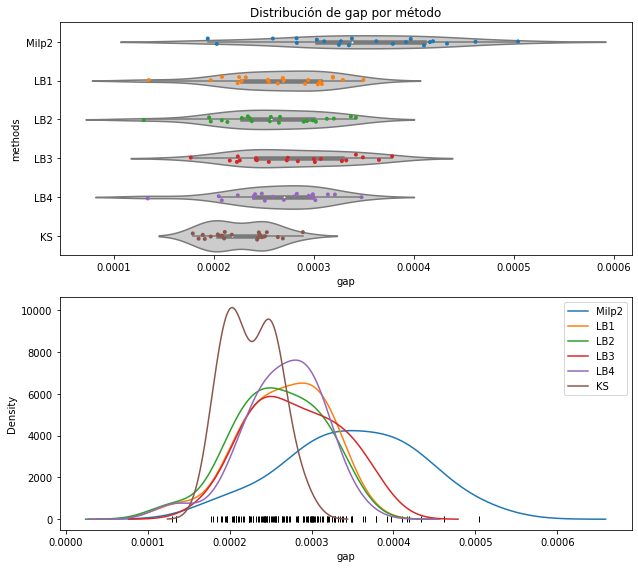

In [52]:
if True:
  import seaborn as sns
  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 8))
  sns.violinplot(
      x       = df1.gap,
      y       = df1.method,
      color   = '.8',
      ax      = axs[0]  )
  sns.stripplot(
      x       = df1.gap,
      y       = df1.method,
      data    = df1,
      size    = 4,
      jitter  = 0.1,
      ax      = axs[0]  )
  axs[0].set_title('Distribución de gap por método')
  axs[0].set_ylabel('methods')
  axs[0].set_xlabel('gap')

  for i in df1.method.unique():
      datos_temp = df1[df1.method == i]['gap']
      datos_temp.plot.kde(ax=axs[1], label=i)
      axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

  axs[1].set_xlabel('gap')
  axs[1].legend()

  fig.tight_layout()

## Functions

In [53]:
def means_test(alternative,labels,samples,alpha=0.05):
## Ho(Accepted): The difference between the pairs follows a symmetric distribution around zero.
## Ha(Rejected): The difference between the pairs does not follow a symmetric distribution around zero.
## We conduct the Mann-whitney U or  two-sample t test alternative= {'two-sided', 'greater', 'less'} 
# ==============================================================================
  ## Tipo de prueba
    if alternative == 'less':
      message1='\t: We fail to reject the null hypothesis; Ho accepted: \n\tThe difference between the pairs follows a symmetric distribution around zero.'
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t'+labels[0]+'\'s mean is less than '+labels[1]+'\'s mean.'
    if alternative == 'greater':
      message1='\t: We fail to reject the null hypothesis; Ho accepted: The difference between the pairs follows a symmetric distribution around zero.'
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t'+labels[0]+'\'s mean is greater than '+labels[1]+'\'s mean.'
    if alternative == 'two-sided':
      message1='\t: We fail to reject the null hypothesis; Ho accepted: The median difference between the pairs follows a symmetric distribution around zero.'
      message2='\t: *We reject the null hypothesis and accept alternative hypothesis Ha:\n\t The median difference between the pairs not follows a symmetric distribution around zero.'

    ## Checamos normalidad 
    normal=[]
    i = 0
    for s in samples:
      if shapiro(s).pvalue > alpha:
        normal.append(True)
      else:
        # print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe reject the null hypothesis and accept Ha: Sample is not from the normal distributions.')
        normal.append(False)
      i = i + 1

    ## Checamos homocedasticidad
    levene_test = stats.levene(samples[0], samples[1], center='mean')
    equalvar=False
    if levene_test.pvalue > alpha:
        equalvar =True
    #   print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
    # else:
    #   print(labels[0],labels[1],'\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe reject the Ho and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

    if normal[0]==True and normal[1]==True and equalvar==True: ## T-test two samples
      print(labels[0],labels[1],stats.ttest_ind(samples[0], samples[1], alternative=alternative) )
      if stats.ttest_ind(samples[0], samples[1], alternative=alternative).pvalue > alpha:
          print('\t',message1)
      else:
          print('\t',message2)
    else: ## Mann-whitney U Test
      print(labels[0],labels[1],stats.mannwhitneyu(samples[0], samples[1], alternative=alternative) )
      if stats.mannwhitneyu(samples[0], samples[1], alternative=alternative).pvalue > alpha:
          print('\t',message1)
      else:
          print('\t',message2)
## Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 
## (As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. 
## Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)
## (As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. 
## Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

## Pruebas de Normalidad de todos los métodos

In [19]:
# conduct the  Shapiro-Wilk Test
## https://www.geeksforgeeks.org/how-to-perform-a-shapiro-wilk-test-in-python/
## This is a hypotheses test and the two hypotheses are as follows:
## Ho(Accepted): Sample is from the normal distributions.(Po>0.05)
## Ha(Rejected): Sample is not from the normal distributions.
## Example 1: Shapiro-Wilk test on the normally distributed sample in Python
## In this example, we will be simply using the shapiro() function from 
## the scipy.stats library to Conduct a Shapiro-Wilk test on the randomly generated data with 500 data points in python. 

samples= (harjk,harduc,milp2,lbc1,lbc2,lbc3,lbc4,ks)
labels = ['Harjk','Harduc','MILP2','LB1','LB2','LB3','LB4','KS']
normal =[]
i = 0
print('Shapiro-Wilk test (Normality)')
for s in (samples):
  # print(labels[i],':', shapiro(s).statistic, shapiro(s).pvalue)
  if shapiro(s).pvalue > 0.05:
    print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: \n\tSample is from the normal distributions.(Po>0.05)')
    normal.append(True)
  else:
    print(labels[i],'\t:',round(shapiro(s).statistic,4),'\t',round(shapiro(s).pvalue,4),'\tWe reject the null hypothesis and accept alternative hypothesis Ha: \n\tSample is not from the normal distributions.')
    normal.append(False)
  i = i + 1
## Output Interpretation:
## Returns: (statistic: The test statistic, p-value: The p-value for the hypothesis test)
## a)Since in the above example, the p-value is 0.73 which is more than the threshold(0.05) which is the alpha(0.05) then we fail to reject the null hypothesis 
##   i.e. we do (not have sufficient evidence) to say that sample does not come from a normal distribution.
## b)Since in the above example, the p-value is 0.0001 which is less than the alpha(0.05) then we reject the null hypothesis 
##   i.e. we (have sufficient evidence) to say that sample does not come from a normal distribution.

Shapiro-Wilk test (Normality)
Harjk 	: 0.8697 	 0.0095 	We reject the null hypothesis and accept alternative hypothesis Ha: 
	Sample is not from the normal distributions.
Harduc 	: 0.9895 	 0.997 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
MILP2 	: 0.9827 	 0.9583 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
LB1 	: 0.9622 	 0.562 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
LB2 	: 0.9707 	 0.7479 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
LB3 	: 0.9681 	 0.6901 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
LB4 	: 0.953 	 0.3878 	We fail to reject the null hypothesis; Ho accepted: 
	Sample is from the normal distributions.(Po>0.05)
KS 	: 0.9419 	 0.2371 	We fail to reject the null hypothesi

## Estadistica inferencial para los métodos contructivos

### Pruebas de Homocedasticidad entre los resultados de Harduc y Harjk

In [20]:
## homocedasticidad.
## https://www.cienciadedatos.net/documentos/pystats07-test-homocedasticidad-heterocedasticidad-python.html
## https://stats.stackexchange.com/questions/135232/bartletts-test-vs-levenes-test
## We conducting Levene’s Test or Bartlett’s Test of homogeneity of variance we are dealing with two hypotheses. These two are simply put:
## Ho(Accepted): the variances are equal across all samples
## Ha(Rejected): the variances are not equal across all samples

# Levene test
# ==============================================================================
levene_test = stats.levene(harjk, harduc, center='mean')
# print('Levene test')
print(levene_test)
equalvar=False
if levene_test.pvalue > 0.05:
    print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
    equalvar=True
else:
    print('[Harjk,Harduc]\t:',round(levene_test.statistic,4),round(levene_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

# Fligner-Killeen
# ==============================================================================
fligner_test = stats.fligner(harjk, harduc, center='mean')
print(fligner_test)
if fligner_test.pvalue > 0.05:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)')
else:
    print('[Harjk,Harduc]\t:',round(fligner_test.statistic,4),round(fligner_test.pvalue,4),'\tWe reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)')

## Output Interpretation:
## a) This means, for example, that if we get a p-value larger than 0.05 we can assume 
## hat our data is heteroscedastic and we can continue carrying out a parametric test 
## such as the two-sample t-test. 
## b) If we, on the other hand, get a statistically 
## significant result we may want to carry out the Mann-Whitney U test. 
## Ninguno de los test muestra evidencias para rechazar la hipótesis de que los 
## dos grupos tienen la misma varianza, homocedasticidad. p-value >>>> 0.05

LeveneResult(statistic=5.36168703416012, pvalue=0.025795143902486665)
[Harjk,Harduc]	: 5.3617 0.0258 	We reject the null hypothesis and accept Ha: the variances are not equal across all samples. (Po<=0.05)
FlignerResult(statistic=3.8028649309663862, pvalue=0.051164967531499975)
[Harjk,Harduc]	: 3.8029 0.0512 	We fail to reject the null hypothesis; Ho accepted: the variances are equal across all samples. (Po>0.05)


## Test of differences between Harduc and Harjk means  


In [21]:
samples= (harduc,harjk,)
labels = ['Harduc','Harjk']
means_test('less',labels,samples,alpha=0.01)

## Output Interpretation:
## In the above example, the p-value is 0.2 which is less than the threshold(0.05) which is the alpha(0.05) 
## i.e. p-value<alpha which means the sample is of the same distribution 
## and the sample distributions are equal if in the case if the p-value>0.05 than it would be opposite.

Harduc Harjk MannwhitneyuResult(statistic=31.0, pvalue=9.931155521762101e-07)
	 	: *We reject the null hypothesis and accept alternative hypothesis Ha:
	Harduc's mean is less than Harjk's mean.


## Analysis of variance between all methods using ANOVA or Kruskal-wallis 

https://www.geeksforgeeks.org/how-to-perform-a-kruskal-wallis-test-in-python/


In [22]:
## Ho(Accepted): The mean for each population is equal.
## Ha(Rejected): At least one population mean is different from the rest.
## We conduct the ANOVA or Kruskal-wallis test
# ==============================================================================
labels = ['MILP2','LB1','LB2','LB3','LB4','KS']

if normal[2]==True and normal[3]==True and normal[4]==True and normal[5]==True and normal[6]==True and normal[7]==True:
  print('ANOVA test')
  print(stats.f_oneway(milp2,lbc1,lbc2,lbc3,lbc4,ks))
  if stats.f_oneway(milp2,lbc1,lbc2,lbc3,lbc4,ks).pvalue > 0.01:
      print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted:\n\tThe mean for each population is equal.')
  else:
      print('[All heuristics]:','\tWe reject the null hypothesis and accept alternative hypothesis Ha:\n\tAt least one population mean is different from the rest.')
else:
  print('kruskal-wallis test') 
  print(stats.kruskal(milp2,lbc1,lbc2,lbc3,lbc4,ks))
  if stats.kruskal(milp2,lbc1,lbc2,lbc3,lbc4,ks).pvalue > 0.01:
      print('[All heuristics]:','\tWe fail to reject the null hypothesis; Ho accepted: \n\tThe mean for each population is equal.')
  else:
      print('[All heuristics]:','\tWe reject the null hypothesis and accept alternative hypothesis Ha: \n\tAt least one population mean is different from the rest.')

## Output Interpretation:
## Null Hypothesis: There is no significant difference between the given conditions of measurement OR the probability 
## distributions for all the conditions are the same. (Medians are same)
## In this example, the test statistic is 13.3514 and the corresponding p-value is p = 0.00126. 
## Since this p-value is less than 0.05, we can reject the null hypothesis that the mean response time is the same for all three drugs.
## In other words, we have sufficient evidence to conclude that the type of drug used leads to statistically significant differences in response time.

ANOVA test
F_onewayResult(statistic=11.501821471785176, pvalue=4.390420615958517e-09)
[All heuristics]: 	We reject the null hypothesis and accept alternative hypothesis Ha:
	At least one population mean is different from the rest.


## Post-Hoc analysis

In [23]:
## We applying the Post Hoc analysis with Mann-whitney U Test to know which pairs have a significant difference between them.
## The Mann–Whitney U test is applied to independent samples.
# ==============================================================================
## We conduct the Mann-whitney U {“two-sided”, “greater”, “less”}, optional
# ==============================================================================
samples= [ milp2,lbc1,lbc2,lbc3,lbc4,ks ]
labels = ['MILP2','LB1','LB2','LB3','LB4','KS']
means  = []
print('\n RANKING ==============================================================================\n')
i = 0
ordered_labels  = []
ordered_samples = []
for s in samples:
  means.append((i,np.mean(s)))
  i = i + 1
means.sort(key=lambda tup: tup[1], reverse=False) ##reverse=False
i = 0
for m in means:  
  ordered_samples.append(samples[m[0]])
  ordered_labels.append(labels[m[0]])
  i = i + 1
  print(labels[m[0]],m[1])
print('\n Ha:less,alpha=0.05 ==============================================================================\n')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.05)
print('\n Ha:less,alpha=0.01 ==============================================================================\n')
for i in range(len(ordered_labels)):
  for j in range(len(ordered_labels)):
    if j > i:
      means_test('less',(ordered_labels[i],ordered_labels[j]),(ordered_samples[i],ordered_samples[j]),alpha=0.01)


 RANKING ==============================================================================

KS 0.0002261952380952381
LB2 0.00025810000000000004
LB4 0.000264547619047619
LB1 0.00026578571428571433
LB3 0.00028010952380952387
MILP2 0.0003492190476190476

 Ha:less,alpha=0.05 ==============================================================================

KS LB2 Ttest_indResult(statistic=-2.362103718307748, pvalue=0.011563056345096741)
	 	: *We reject the null hypothesis and accept alternative hypothesis Ha:
	KS's mean is less than LB2's mean.
KS LB4 Ttest_indResult(statistic=-3.059966965108244, pvalue=0.0019707917617667026)
	 	: *We reject the null hypothesis and accept alternative hypothesis Ha:
	KS's mean is less than LB4's mean.
KS LB1 Ttest_indResult(statistic=-2.982600752915975, pvalue=0.0024250827541624845)
	 	: *We reject the null hypothesis and accept alternative hypothesis Ha:
	KS's mean is less than LB1's mean.
KS LB3 MannwhitneyuResult(statistic=98.0, pvalue=0.0010738818707128868)


## Descartes

ZeroDivisionError: ignored

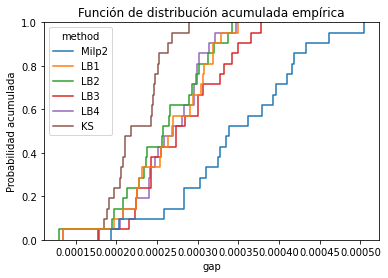

In [24]:
## https://www.cienciadedatos.net/documentos/pystats08-comparacion-distribuciones-test-kolmogorov-smirnov-python.html
# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.ecdfplot(data=df1, x='gap', hue='method', ax=ax)
ax.set_title("Función de distribución acumulada empírica")
ax.set_ylabel("Probabilidad acumulada");
# Ajuste de las funciones ecdf con cada muestra
# ==============================================================================
ecdf_harjk  = ECDF(df1.loc[df1.method == 'Harjk' , 'gap'])
ecdf_harduc = ECDF(df1.loc[df1.method == 'Harduc', 'gap'])
# Estimación de la probabilidad acumulada de cada valor de salario observado
# ==============================================================================
grid_gap = np.sort(df1.gap.unique())
prob_acumulada_ecdf_harjk  = ecdf_harjk( grid_gap)
prob_acumulada_ecdf_harduc = ecdf_harduc(grid_gap)
# Distancia Kolmogorov–Smirnov
# ==============================================================================
abs_dif = np.abs(prob_acumulada_ecdf_harjk - prob_acumulada_ecdf_harduc)
distancia_ks = np.max(abs_dif)
print("Distancia Kolmogorov–Smirnov: {distancia_ks :.4f}")

In [ ]:
# Conduct the Kruskal-Wallis Test
result = stats.kruskal(milp2,lbc1,lbc2,lbc3,lbc4,ks)

# Print the result
print(result)
#Kruskal-Wallis test discussion:  In this example, the test statistic comes out to be equal to 87 and the corresponding p-value is 2.1856E-17. 
#(As the p-value is not less than 0.05, we cannot reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to claim that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)
#(As the p-value is less than 0.05, we reject the null hypothesis that the median of optimality gap is the same for all groups. Hence, We don’t have sufficient proof to reject that the different types of methods used to lead to statistically significant differences in the acuracy of methods.)

In [ ]:
## https://www.geeksforgeeks.org/data-visualization-with-python-seaborn/
nor  = np.random.normal(size=100) 
nor  = nor + 5
ale  = np.random.uniform(size=100) 
nor1 = np.random.normal(size=100) 
nor1  = nor1 + 5
ale1 = np.random.uniform(size=100)
ale1  = ale1 + 5
nor2 = np.random.normal(size=100)
nor2  = nor2 + 5
ale2 = np.random.uniform(size=100)  #'N','A','N1','A1','N2','A2',,nor,ale,nor1,ale1,nor2,ale2
ale2  = ale2 + 5
fig, ax = plt.subplots(figsize=(8, 6))
method1 = ['nor' ]*(len(nor))
method2 = ['ale' ]*(len(ale))
method3 = ['nor1']*(len(nor1))
method4 = ['ale1']*(len(ale1))
method5 = ['nor2']*(len(nor2))
method6 = ['ale2']*(len(ale2))
method  = method1 + method2 + method3 + method4 + method5 + method6
data    = np.concatenate((nor,ale,nor1,ale1,nor2,ale2), axis=0)
# initialise data of lists.
data = {'gap'       :data,
        'method'  :method}  
df1 = pd.DataFrame( data )
sns.histplot(df1, x="gap", hue="method", element="step") #,bins=15

print('Mann-whitney U test NOR-ALE')
if stats.mannwhitneyu(ale, nor, alternative='less').pvalue > 0.05:
    print('[ale,nor]\t:','We fail to reject the null hypothesis; Ho accepted: The median difference between the pairs follows a symmetric distribution around zero.')
else:
    print('[ale,nor]\t:','We reject the null hypothesis and accept Ha: The median difference is positive α=0.05. Ale\'s mean is lower than Nor\'s mean.')

print('kruskal-wallis test nor,ale1,nor1,ale2,nor2') ## ale,
if stats.kruskal(ale,nor,nor1,nor2).pvalue > 0.05:
    print('[All heuristics]\t:','We fail to reject the null hypothesis; Ho accepted: The mean for each population is equal.')
else:
    print('[All heuristics]\t:','We reject the null hypothesis and accept Ha: At least one population mean is different from the rest: α=0.05.')


### Wilcoxon test
https://www.geeksforgeeks.org/how-to-conduct-a-wilcoxon-signed-rank-test-in-python/

https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

https://www.cienciadedatos.net/documentos/18_prueba_de_los_rangos_con_signo_de_wilcoxon

Comparaxion medias

https://www.cienciadedatos.net/documentos/pystats11-wilcoxon-mann-whitney-u-test-python

https://www.cienciadedatos.net/documentos/pystats10-t-test-python.html

https://www.cienciadedatos.net/documentos/pystats09-analisis-de-varianza-anova-python.html

https://www.cienciadedatos.net/documentos/15_inferencia_para_proporciones